In [2]:
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from IPython.display import Audio

In [3]:
dataset_path = "../input/speech-commends"
files = os.listdir(f"{dataset_path}")
print("Fichiers disponibles :", files)

Fichiers disponibles : ['no', 'two', 'backward', 'four', 'five', 'nine', 'right', 'follow', '_background_noise_', 'visual', 'off', 'LICENSE', 'yes', 'six', 'dog', 'testing_list.txt', 'learn', 'left', 'bird', 'README.md', 'forward', 'wow', 'zero', 'eight', 'bed', 'go', 'house', 'tree', 'validation_list.txt', 'seven', 'on', 'three', 'one', 'down', 'stop', 'up', 'happy', 'marvin', 'cat', 'sheila']


In [9]:
audio_file = os.path.join(dataset_path, "yes", "004ae714_nohash_0.wav")

# charger l'audio
audio, sr = librosa.load(audio_file, sr=None) #None pour garder la fréquence originale

# Lecture de l'audio
Audio(audio, rate=sr)

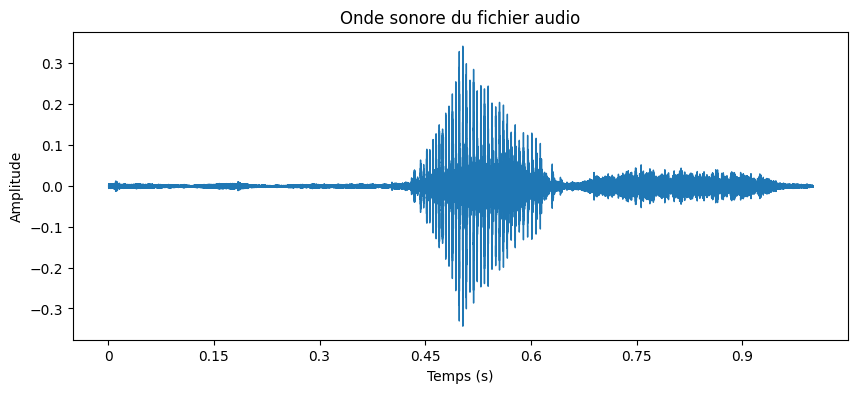

In [13]:
# visualisation du signal audio

# Affichage de l'onde Sonore
plt.figure(figsize=(10,4))
librosa.display.waveshow(audio, sr=sr)
plt.title("Onde sonore du fichier audio")
plt.xlabel("Temps (s)")
plt.ylabel("Amplitude")
plt.show()

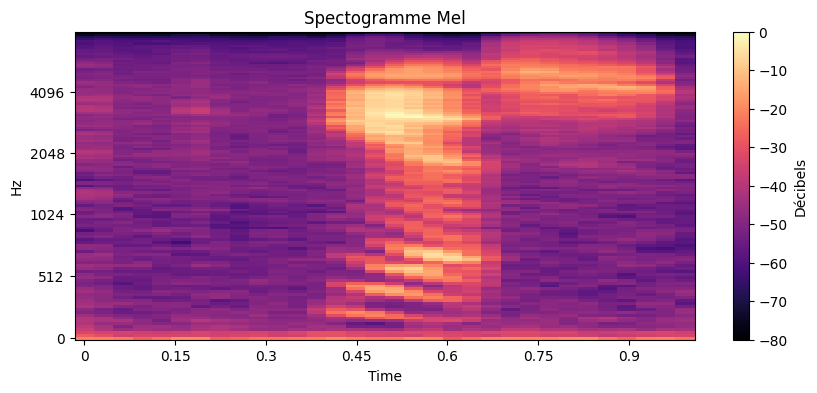

In [14]:
# Affichage du spectogramme
spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(spectrogram_db, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(label = "Décibels")
plt.title("Spectogramme Mel")
plt.show()

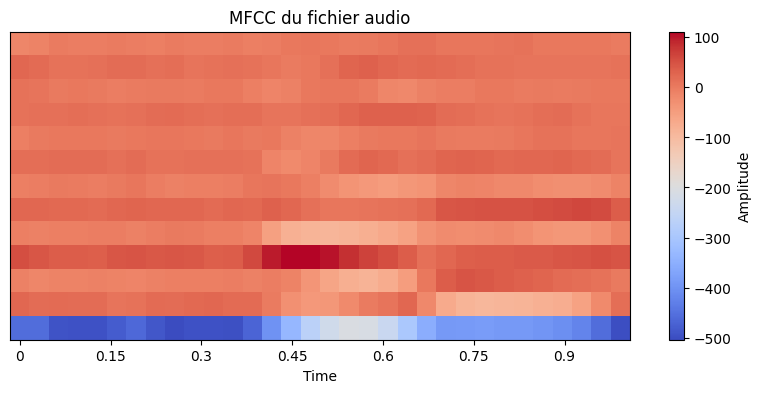

In [15]:
# fonction d'extraction des caractérisques audio MFCC

def extract_mfcc(file_path, max_length=16000):
    # charger l'audio
    audio, sr = librosa.load(file_path, sr=16000)
    audio = librosa.util.fix_length(audio, size=max_length) # Normaliser la durée

    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
    return mfcc.T # Transposer pour obtenir (n_frames, 13)

# Test sur un fichier audio
mfcc_features = extract_mfcc(audio_file)

# Affichage des MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_features.T, sr=sr, x_axis="time")
plt.colorbar(label = "Amplitude")
plt.title("MFCC du fichier audio")
plt.show()

In [16]:
data = []
labels_list = []

# Parcourir les dossiers (chaque dossier correspond à une classe)
labels = [label for label in os.listdir(dataset_path) 
          if os.path.isdir(os.path.join(dataset_path, label)) and not label.startswith("_")]

for label in labels:
    folder_path = os.path.join(dataset_path, label)
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        mfcc = extract_mfcc(file_path)  # Doit retourner (timesteps, features)
        
        # Vérification de la forme des MFCCs
        if len(mfcc.shape) == 2:
            data.append(mfcc)  # On garde la forme 2D
        else:
            print(f"Attention: MFCC de {file_path} a une forme inattendue {mfcc.shape}")

        labels_list.append(labels.index(label))  # Encodage des labels

# Convertir en numpy array et s'assurer qu'on a bien 3 dimensions
X = np.array(data)  # Devrait être (n_samples, timesteps, features)
y = np.array(labels_list)

# Diviser le dataset en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vérification des dimensions
print("Shape de X:", X.shape)  # Devrait être (n_samples, timesteps, features)
print("Shape de X_train:", X_train.shape)
print("Shape de y_train:", y_train.shape)

Shape de X: (105829, 32, 13)
Shape de X_train: (84663, 32, 13)
Shape de y_train: (84663,)


In [17]:
# Vérification des dimensions de test
print("Shape de X_test:", X_test.shape)
print("Shape de y_test:", y_test.shape)

# Affichage des premières lignes après extraction des caractérisques audio MFCC
X_flat = X.reshape(X.shape[0], -1)  # (105829, 32*13)
X_df = pd.DataFrame(X_flat)
y_df = pd.DataFrame(labels, columns=["Label"])
print(" X_df:", X_df.head())  
print(" y_df:", y_df.head())  


Shape de X_test: (21166, 32, 13)
Shape de y_test: (21166,)
 X_df:           0           1          2          3          4          5    \
0 -656.906860    0.000000   0.000000   0.000000   0.000000   0.000000   
1 -355.121674  107.901505 -32.346680 -30.687271  28.848684  24.691446   
2 -499.927429    9.145807  16.738655  10.664015   1.646243  11.268918   
3 -760.691833    0.000000   0.000000   0.000000   0.000000   0.000000   
4 -627.054260   15.148926  12.835129  10.631998   8.717432   6.118010   

         6          7          8          9    ...        406        407  \
0   0.000000   0.000000   0.000000   0.000000  ...   5.334963   1.342156   
1 -18.829395 -27.433386 -17.730251  10.458147  ...  -7.129129 -22.767555   
2  -9.282516   3.301995  -5.363275  -6.540828  ...  31.568417  21.567188   
3   0.000000   0.000000   0.000000   0.000000  ...   0.000000   0.000000   
4   2.447987  -1.170020  -3.349580  -4.124393  ...  17.625942  14.101124   

         408       409       410      

In [18]:
# Adapter y_train pour avoir la même dimension que la sortie du modèle
y_train = np.expand_dims(y_train, axis=-1)  # Devient (batch_size, 1)
y_train = np.tile(y_train, (1, X_train.shape[1]))  # Devient (batch_size, timesteps)

y_test = np.expand_dims(y_test, axis=-1)
y_test = np.tile(y_test, (1, X_test.shape[1]))

# Vérification des formes
print("Shape de y_train:", y_train.shape)  # Doit être (batch_size, timesteps)
print("Shape de y_test:", y_test.shape)


Shape de y_train: (84663, 32)
Shape de y_test: (21166, 32)


In [26]:
# Création du modéle
num_classes = len(labels)

print("Labels:", labels)

model = keras.Sequential([
    layers.Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Bidirectional(layers.GRU(416, return_sequences=True)),
    layers.BatchNormalization(),
    layers.Bidirectional(layers.GRU(208, return_sequences=True)),
    layers.BatchNormalization(),
    layers.Bidirectional(layers.GRU(104, return_sequences=False)),  # Plus de return_sequences ici
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Annuler l'expansion de y_train et y_test
y_train = y_train[:, 0] if len(y_train.shape) > 1 else y_train
y_test = y_test[:, 0] if len(y_test.shape) > 1 else y_test

# Utiliser sparse_categorical_crossentropy
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


model.summary()

Labels: ['no', 'two', 'backward', 'four', 'five', 'nine', 'right', 'follow', 'visual', 'off', 'yes', 'six', 'dog', 'learn', 'left', 'bird', 'forward', 'wow', 'zero', 'eight', 'bed', 'go', 'house', 'tree', 'seven', 'on', 'three', 'one', 'down', 'stop', 'up', 'happy', 'marvin', 'cat', 'sheila']


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ masking_3 (Masking)                  │ (None, 32, 13)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ (None, 32, 832)             │       1,075,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 832)             │           3,328 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ (None, 32, 416)             │       1,300,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 416)             │           1,664 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_11 (Bidirectional)     │ (None, 208)                 │         325,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │          13,376 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 35)                  │           2,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,722,563 (10.39 MB)

 Trainable params: 2,720,067 (10.38 MB)

 Non-trainable params: 2,496 (9.75 KB)

In [27]:
# Entrainement du modéle
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/20
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 65s 22ms/step - accuracy: 0.5760 - loss: 1.5150 - val_accuracy: 0.8275 - val_loss: 0.5847
Epoch 2/20
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 58s 22ms/step - accuracy: 0.8212 - loss: 0.6201 - val_accuracy: 0.8573 - val_loss: 0.4742
Epoch 3/20
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 58s 22ms/step - accuracy: 0.8445 - loss: 0.5367 - val_accuracy: 0.8683 - val_loss: 0.4415
Epoch 4/20
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 58s 22ms/step - accuracy: 0.8569 - loss: 0.4814 - val_accuracy: 0.8711 - val_loss: 0.4330
Epoch 5/20
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 58s 22ms/step - accuracy: 0.8658 - loss: 0.4640 - val_accuracy: 0.8745 - val_loss: 0.4244
Epoch 6/20
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 58s 22ms/step - accuracy: 0.8684 - loss: 0.4436 - val_accuracy: 0.8788 - val_loss: 0.4066
Epoch 7/20
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 58s 22ms/step - accuracy: 0.8760 - loss: 0.4241 - val_accuracy: 0.8881 - val_loss: 0.3816
Epoch 8/20
2646/2646 ━━━━━━━━━━━━━━━━━━━━ 58s 22ms/step - accuracy: 0.8779 -

662/662 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8873 - loss: 0.3857
Précision sur le test 0.8881224393844604


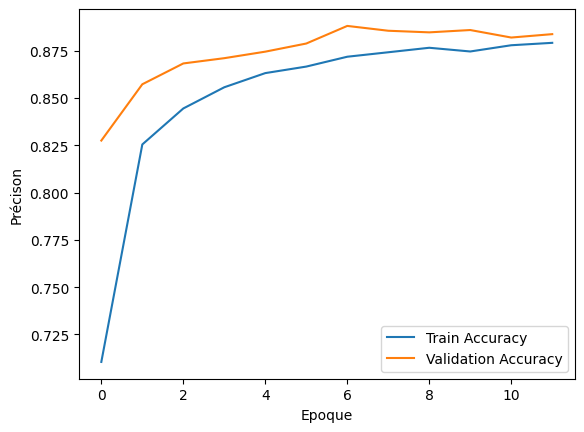

In [28]:
# Evaluation sur les données de Test
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Précision sur le test", test_acc)

# courbe d'apprentissage
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoque')
plt.ylabel('Précison')
plt.legend()
plt.show()

In [10]:
# fonction pour la prédiction
def predict_audio(file_path):
    mfcc = extract_mfcc(file_path)
    mfcc = np.expand_dims(mfcc, axis=0)
    prediction = model.predict(mfcc)
    predicted_label = labels[np.argmax(prediction)]
    return predicted_label

# Test avec un fichier audio
test_file = os.path.join(dataset_path, "backward", "017c4098_nohash_0.wav")
print("Prédiction:", predict_audio(test_file))

# Ecouter le fichier audio
Audio(test_file)

NameError: name 'extract_mfcc' is not defined

In [31]:
from huggingface_hub import notebook_login
notebook_login()

In [32]:
model.save("audio_recognition.h5")

In [33]:
from huggingface_hub import HfApi

repo_id = "sonnayvan237/Audio_recognition"  # Remplace avec ton username et nom du repo
api = HfApi()
api.upload_file(
    path_or_fileobj="audio_recognition.h5",
    path_in_repo="audio_recognition.h5",
    repo_id=repo_id,
    repo_type="model"
)

audio_recognition.h5:   0%|          | 0.00/32.8M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sonnayvan237/Audio_recognition/commit/65f774ee01bfac8cf3f74fbc68a3eed8d69d55c3', commit_message='Upload audio_recognition.h5 with huggingface_hub', commit_description='', oid='65f774ee01bfac8cf3f74fbc68a3eed8d69d55c3', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sonnayvan237/Audio_recognition', endpoint='https://huggingface.co', repo_type='model', repo_id='sonnayvan237/Audio_recognition'), pr_revision=None, pr_num=None)